In [303]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import activations
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from math import *

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


# 1. Generate Data

(-3.22, 658.44)
67


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


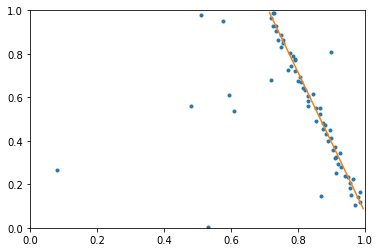

In [304]:
sigma_noise = [2, 2]
image_size = (200, 200)

def generate_line(image):
    a = int(random.uniform(-10, 10) * 100) / 100
    p = (np.random.randint(image[0]), np.random.randint(image[1]))
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2, image):
    x1, y1 = int(image[0]*p1[0]), int(image[1]*p1[1])
    x2, y2 = int(image[0]*p2[0]), int(image[1]*p2[1])
    if (x2-x1) != 0:
        a = int((y2-y1)/(x2-x1) * 100) / 100
    else:
        a = 100
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, image, sigma, n_inliers, n_outliers):
    a, b = line
    L_X = []
    L_Y = []
    Points = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            p = np.array([x, y])
            Points.append(p)
    covariance = np.diag(np.array(sigma) ** 2)
    n_i = max(1, n_inliers // len(Points))
    for point in Points:
        sample = np.random.multivariate_normal(point, covariance, n_i)
        sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
        sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
        L_X.extend(sample_X)
        L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax, c=None):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.', c=c)

def plot_line(line, image, ax, c=None):
    a, b = line
    X = []
    Y = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            X.append(x/image[0])
            Y.append(y/image[1])
    ax.plot(X, Y, c=c)
    
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line = generate_line(image_size)
print(line)
D = generate_data(line, image_size, sigma_noise, 100, 10)
plot_data(D, ax)
plot_line(line, image_size, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines

(-0.48, 119.6)
(9.22, -1479.42)
17512
22488
True
area final =  0.5622


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


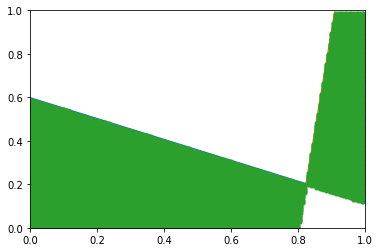

In [305]:
def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def loss_weights(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    area = 1 - (area/(image[0]*image[1]))
    return area

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image_size, ax)
    plot_line(l2, image_size, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x/image[0])
            area_Y.append(k/image[1])
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1

    area = 1 - (area/(image[0]*image[1])) 
    print("area final = ", area)

    fig.show()

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line1 = generate_line(image_size)
print(line1)

line2 = generate_line(image_size)
print(line2)
plot_loss(line1, line2, image_size, ax)

In [306]:
def dist_to_line(p, l, image):
    a, b = l
    x, y = p
    xb, yb = x*image[0], y*image[0]
    d = ((a*xb+b) - yb)/sqrt(1+a*a)
    return d

def dist_points_to_line(data, line, image, n_inliers):
    X, Y = data[0][:n_inliers], data[1][:n_inliers]
    dist = 0
    for i in range(len(X)):
        p = X[i], Y[i]
        dp = dist_to_line(p, line, image)
        dist += dp**2
    return dist

def loss_dist_points(data, line, dist_ref, image, n_inliers):
    dist = dist_points_to_line(data, line, image, n_inliers)
    return dist_ref/dist
    

### Neural network model

In [307]:
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(1024)
        self.bn_4 = nn.BatchNorm1d(512)
        self.bn_5 = nn.BatchNorm1d(256)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]

        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x

class BasePointNet(nn.Module):

    def __init__(self, point_dimension, return_local_features=False):
        super(BasePointNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(1024)

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        if self.return_local_features:
            x = x.view(-1, 1024, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform

class FeaturesPointNet(nn.Module):

    def __init__(self, dropout, point_dimension):
        super(FeaturesPointNet, self).__init__()
        self.base_pointnet = BasePointNet(return_local_features=False, point_dimension=point_dimension)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        #self.fc_3 = nn.Linear(256, num_classes)

        self.bn_1 = nn.BatchNorm1d(512)
        self.bn_2 = nn.BatchNorm1d(256)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        #return F.log_softmax(self.fc_3(x), dim=1), feature_transform
        return x, feature_transform


class Weights(nn.Module):

    
    def __init__(self, dropout=0.3, point_dimension=2):
        super(Weights, self).__init__()
        self.point1 = FeaturesPointNet(dropout, point_dimension)
        self.point2 = FeaturesPointNet(dropout, point_dimension)

        self.fc_1 = nn.Linear(518, 1)
        
        
    def forward(self, x):
        #print(x.shape)
        
        n = (x.shape[1] - 3)//2
        x1 = x[:, :n]
        x2 = x[:, n:2*n]
        v = x[:, 2*n]
        p1 = x[:, 2*n+1]
        p2 = x[:, 2*n+2]
        #print("x1.shape= ", x1.shape)
        #print("x2.shape= ", x2.shape)
        #print("v.shape = ", v.shape)
        
        assert 2*n+2==x.shape[1]-1
        
        #x1, x2, x3 = x
        #v = x3[:, 0]
        #p1 = x3[:, 1]
        #p2 = x3[:, 2]
        #print("x1.shape= ", x1.shape)
        #print("x2.shape= ", x2.shape)
        #print("v.shape = ", v.shape)
        
        #print("x1 = ", x1.shape)
        x1, feature_transform1 = self.point1(x1)
        x2, feature_transform2 = self.point2(x2)
        #print("feature1.shape = ", x1.shape)
        #print("feature2.shape = ", x2.shape)
        #print(feature_transform1.shape)
        
        x_tot = torch.cat((x1, x2), dim=1)
        #print("x_tot.shape = ", x_tot.shape)

        x = torch.cat((x_tot, v), dim=1)
        x = torch.cat((x, p1), dim=1)
        x = torch.cat((x, p2), dim=1)

        #print("x.shape = ", x.shape)
        #print("x = ", x)
        
        x = F.relu(self.fc_1(x))

        return x #, feature_transform


In [308]:
class FeaturesPointNet2(nn.Module):
    
    def __init__(self):
        super(FeaturesPointNet2, self).__init__()
        self.conv_1 = nn.Conv2d(1, 64, 3, stride=2)
        self.conv_2 = nn.Conv2d(64, 160, 3, stride=2)
        self.conv_3 = nn.Conv2d(160, 160, 3, stride=2)
        self.linear_1 = nn.Linear(160, 1000)
        self.linear_2 = nn.Linear(1000, 1000)
        self.linear_3 = nn.Linear(1000, 100)
        self.maxpool_1 = nn.MaxPool2d(3, stride=2)
        self.maxpool_2 = nn.MaxPool2d(2, stride=2)
        self.maxpool_3 = nn.MaxPool2d(2, stride=2)

    def forward(self, x):

        #print("before transpose :", x.shape)
        x = x.transpose(3, 1)
        x = x.transpose(2, 3)
        #print("after transpose :", x.shape)
        x = F.relu(self.conv_1(x))
        #print("after conv1 :", x.shape)
        x = self.maxpool_1(x)
        #print("after pool1 :", x.shape)
        x = self.conv_2(x)
        #print("after covn2 :", x.shape)
        x = F.relu(x)
        x = self.maxpool_2(x)
        #print("after pool2 :", x.shape)
        #x = F.relu(self.conv_3(x))
        #print("after conv3 :", x.shape)
        #x = self.maxpool_3(x)
        #print("after pool3 :", x.shape)
        x = x.transpose(3, 2)
        x = x.transpose(3, 1)
        #print("after retranspose :", x.shape)
        x = self.linear_1(x)
        #print("after lin1 :", x.shape)
        x = self.linear_2(x)
        #print("after lin2 :", x.shape)
        x = self.linear_3(x)
        #print("after lin3 :", x.shape)
        
        return x
    

class Weights2(nn.Module):

    
    def __init__(self):
        super(Weights2, self).__init__()
        self.point1 = FeaturesPointNet2()
        self.point2 = FeaturesPointNet2()

        self.fc_1 = nn.Linear(206, 1)
        
        
    def forward(self, x):
        #print("size = ...")
        x1, x2, x3 = x
        v = x3[:, 0]
        p1 = x3[:, 1]
        p2 = x3[:, 2]
        #print("x1.shape= ", x1.shape)
        #print("x2.shape= ", x2.shape)
        #print("v.shape = ", v.shape)
        
        #print("x1 :", x1.shape)
        x1 = self.point1(x1)
        #print("x2 :", x2.shape)
        x2 = self.point2(x2)
        #print("feature1.shape = ", x1.shape)
        #print("feature2.shape = ", x2.shape)
        #print(feature_transform1.shape)
        
        #print("x1=", x1.shape)
        #print("x2=", x2.shape)
        x1 = x1[:, 0, 0, :]
        x2 = x2[:, 0, 0, :]
        #print(x1.shape)
        #print(x2.shape)
        x_tot = torch.cat((x1, x2), dim=1)
        #print("x_tot.shape = ", x_tot.shape)
        #print("v.shape =", v.shape)

        x = torch.cat((x_tot, v), dim=1)
        x = torch.cat((x, p1), dim=1)
        x = torch.cat((x, p2), dim=1)

        #print("x.shape = ", x.shape)
        #print("x = ", x)
        
        x = F.relu(self.fc_1(x))

        return x
        
        
   
    

In [309]:
sigma_noise = [2, 2]
image_size = (400, 400)
nbr_inliers=300
nbr_outliers=400
size_patch = (8, 8)


In [310]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return sqrt((x1-x2)**2+(y1-y2)**2)

def reorder(L, M):
    p = L[-1]
    d = M[-1]
    k = len(L) - 2
    while k >= 0 and M[k] > d:
        L[k+1] = L[k]
        M[k+1] = M[k]
        k -= 1
    L[k+1] = p
    M[k+1] = d

def nearest_neighbors(data, i, k):
    p = (data[0][i], data[1][i])
    L = []
    M = []
    n = len(data[0])
    for j in range(n):
        (x, y) = (data[0][j], data[1][j])
        d = dist((x, y), p)
        if len(L) < k:
            L.append((x, y))
            M.append(d)
            reorder(L, M)
        else:
            d2 = M[-1]
            if d < d2:
                L[-1] = (x, y)
                M[-1] = d
                reorder(L, M)
    return L

def get_neighborhood_patch(data, k, image, size, scale=(1, 1)):
    scale_x, scale_y = scale
    size_x, size_y = size
    n = len(data[0])
    (x, y) = data[0][k]*image[0], data[1][k]*image[1]
    L = [[0]*(2*size_x+1) for _ in range(2*size_y+1)]
    for i in range(n):
        (xb, yb) = data[0][i]*image[0], data[1][i]*image[1]
        dx = xb-x
        if abs(dx) < scale_x/2.:
            lx = 0
        elif dx >=0.5:
            dx = dx - scale_x/2.
            lx = floor(dx/scale_x)+1
        elif dx <= -0.5:
            dx = dx + scale_x/2.
            lx = floor(dx/scale_x)
        lx += size_x
        
        dy = yb-y
        if abs(dy) < scale_y/2.:
            ly = 0
        elif dy >=0.5:
            dy = dy - scale_y/2.
            ly = floor(dy/scale_y)+1
        elif dy <= -0.5:
            dy = dy + scale_y/2.
            ly = floor(dy/scale_y)
        ly += size_y
        
        
        if lx >= 0 and lx < 2*size_x+1 and ly >= 0 and ly < 2*size_y+1:
            L[2*size_y - ly][lx] += 1
            
            
    for i in range(len(L)):
        for j in range(len(L[0])):
            r = L[i][j]
            L[i][j] = [r]
    
    return L

def get_neighbors_radius(data, k, image, radius):
    radius_x, radius_y = radius
    n = len(data[0])
    L = []
    (x, y) = (data[0][k]*image[0], data[1][k]*image[1])
    for i in range(n):
        (xb, yb) = data[0][i]*image[0], data[1][i]*image[1]
        if (abs(xb-x) < radius_x and abs(yb-y) < radius_y):
            L.append([xb, yb])
    return L

line = generate_line(image_size)
data = generate_data(line, image_size, sigma_noise, 200, 50)


[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


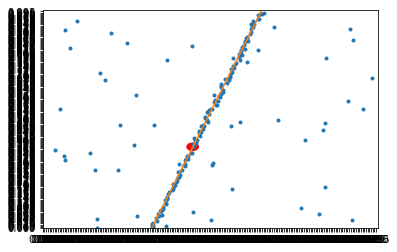

In [311]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.xaxis.set_ticks(np.arange(0, 1, (2./image_size[0])))
ax.yaxis.set_ticks(np.arange(0, 1, (2./image_size[1])))
plot_data(data, ax)
plot_line(line, image_size, ax)
k = np.random.randint(len(data[0]))
L = get_neighborhood_patch(data, k, image_size, (10, 10), scale=(3, 3))
#L = get_neighbors_radius(data, k, image_size, (5, 5))
for x in L:
    print(x)
circle_1 = plt.Circle((data[0][k], data[1][k]), 7./image_size[0], color='r')
print(data[0][k]*image_size[0], data[1][k]*image_size[1])
ax.add_artist(circle_1)
#plt.grid()
fig.show()
#plt.savefig('test.png')

In [312]:
def center_points(points, p):
    (x, y) = p
    L = []
    for point in points:
        (xp, yp) = point
        L.append([xp-x, yp-y])
    return L

def compute_features_k(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    k = 10
    x1 = center_points(nearest_neighbors(data, i1, k), p1)
    x2 = center_points(nearest_neighbors(data, i2, k), p2)
    feature = x1+x2
    feature.append(vec)
    feature.append([p1[0], p1[1]])
    feature.append([p2[0], p2[1]])
    return feature

def compute_features_patch(data, i1, i2, image):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    scale = (1, 1)
    x1 = get_neighborhood_patch(data, k, image_size, size_patch, scale)
    x2 = get_neighborhood_patch(data, k, image_size, size_patch, scale)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)

def compute_features_radius(data, i1, i2, image):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    radius = (5, 5)
    x1 = center_points(get_neighbors_radius(data, i1, image, radius), p1)
    x2 = center_points(get_neighbors_radius(data, i2, image, radius), p2)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)
    

def generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers, loss = 1):
    Lines = []
    Datas = []
    X = []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        n_inliers_precise = len(data[0]) - nbr_outliers
        dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                feature = compute_features_k(data, i1, i2)
                X.append(feature)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                if loss==0:
                    area = loss_weights(line_ref, line, image)
                elif loss==1:
                    area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                Y.append([area])
                
    #print(len(X1), len(X2), len(X3))
    X_tensor = torch.tensor(X)
    Y_tensor = torch.Tensor(Y)
    #print(X_nn_tensor.shape)
    
    return (X_tensor, Y_tensor)

def generate_training_data_patch(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers):
    Lines = []
    Datas = []
    X1, X2, X3 = [], [], []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        n_inliers_precise = len(data[0]) - nbr_outliers
        dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, image)
                X1.append(feature1)
                X2.append(feature2)
                X3.append(feature3)
               
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                #area = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                Y.append([area])
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor2 = torch.Tensor(X2)
    print(X_tensor2.shape)
    X_tensor3 = torch.Tensor(X3)
    print(X_tensor3.shape)
    
    
    return ((X_tensor1, X_tensor2, X_tensor3), Y_tensor)


def split_training(xy, prop=0.1):
    (X, Y) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    x_train = X[k:]
    y_train = Y[k:]
    return ((x_test, y_test), (x_train, y_train))

def split_training_bis(xy, prop=0.1):
    ((X1, X2, X3), Y) = xy
    k = int(prop*len(X1))
    x_test1 = X1[:k]
    x_test2 = X2[:k]
    x_test3 = X3[:k]
    y_test = Y[:k]
    x_train1 = X1[k:]
    x_train2 = X2[k:]
    x_train3 = X3[k:]
    y_train = Y[k:]
    return (((x_test1, x_test2, x_test3), y_test), ((x_train1, x_train2, x_train3), y_train))

In [313]:
#input_dim = size_patch[0]*2+1
model = Weights().to(DEVICE)
model_old_loss = Weights().to(DEVICE)

model_patch = Weights2().to(DEVICE)

In [314]:
def loss_func(y1, y2):
    n = len(y1[0])
    s = 0
    for k in range(n):
        print(y1[k][0], y2[k][0])
        s += abs(y1[k][0]-y2[k][0])
    return s

def train_model(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers, loss = 1):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers, loss = loss))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-5))
    print("data generated")
    
    # Train step
    train_ds = TensorDataset(x_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(len(train_dl))
    
    valid_ds = TensorDataset(x_test, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model(xb)
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = sum(loss_fn(model(xb.to(DEVICE)), yb.to(DEVICE)) for xb, yb in valid_dl)
            m_test = sum(len(yb) for xb, yb in valid_dl)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        
        if k == epochs - 1:
            last_weight = model(x_test.to(DEVICE))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))
            

def train_model_patch(model, image, sigma, nbr, nbr_per_line, epochs, batch_size, nbr_inliers, nbr_outliers):
    ((x_test, y_test), (x_train, y_train)) = split_training_bis(generate_training_data_patch(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers))
    #x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
    #x_train, y_train = x_train.to(DEVICE), y_train.to(DEVICE)
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=10**(-7))
    print("data generated")
    
    # Train step
    x_train1, x_train2, x_train3 = x_train
    train_ds = TensorDataset(x_train1, x_train2, x_train3, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    print(len(train_dl))
    
    x_test1, x_test2, x_test3 = x_test
    valid_ds = TensorDataset(x_test1, x_test2, x_test3, y_test)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    m_train = 0
    for k in range(epochs):
        loss_train = 0
        for xb1, xb2, xb3, yb in train_dl:
            xb1, xb2, xb3, yb = xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float(), yb.to(DEVICE).float()
            #print(xb.shape)
            #print(yb.shape)
            model.train()  # <-- here
            optimizer.zero_grad()

            y_predict = model((xb1, xb2, xb3))
            #print(xb.shape)
            loss = loss_fn(y_predict, yb)
            loss_train += loss.item()
            m_train += len(yb)

            loss.backward()
            optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            loss_eval = 0
            m_test = 0
            for xb1, xb2, xb3, yb in valid_dl:
                predict_test = model((xb1.to(DEVICE).float(), xb2.to(DEVICE).float(), xb3.to(DEVICE).float()))
                loss_eval += loss_fn(predict_test, yb.to(DEVICE).float())
                m_test += len(yb)

        print("iteration = ", k+1, " ; loss_train = ", loss_train, " ; loss_eval = ", loss_eval.item())
        
        if k == epochs - 1:
            last_weight = model((x_test1.to(DEVICE).float(), x_test2.to(DEVICE).float(), x_test3.to(DEVICE).float()))
            print(last_weight)
            print(y_test)
            print(sum(abs(last_weight[i][0]-y_test[i][0]) for i in range(len(y_test)))/len(y_test))




In [315]:

train_model(model, image_size, sigma_noise, 5, 100, 5, 100, nbr_inliers, nbr_outliers)
train_model(model_old_loss, image_size, sigma_noise, 5, 100, 5, 100, nbr_inliers, nbr_outliers, loss = 0)
train_model_patch(model_patch, image_size, sigma_noise, 5, 100, 5, 100, nbr_inliers, nbr_outliers)

data generated
5
iteration =  1  ; loss_train =  0.42485957592725754  ; loss_eval =  0.013262555003166199
iteration =  2  ; loss_train =  0.3634098321199417  ; loss_eval =  0.013988504186272621
iteration =  3  ; loss_train =  0.27615437656641006  ; loss_eval =  0.016368651762604713
iteration =  4  ; loss_train =  0.23730775341391563  ; loss_eval =  0.023805269971489906
iteration =  5  ; loss_train =  0.22389902919530869  ; loss_eval =  0.03894909471273422
tensor([[0.1457],
        [0.1875],
        [0.1899],
        [0.1568],
        [0.2142],
        [0.1743],
        [0.1638],
        [0.2018],
        [0.1713],
        [0.2414],
        [0.2568],
        [0.2082],
        [0.1721],
        [0.1968],
        [0.2491],
        [0.1681],
        [0.1893],
        [0.2263],
        [0.1884],
        [0.2602],
        [0.2249],
        [0.1584],
        [0.1682],
        [0.1852],
        [0.1571],
        [0.1666],
        [0.1526],
        [0.1357],
        [0.1897],
        [0.1834],


In [316]:
def mean_weights(weights):
    n = len(weights)
    s = 0.
    for i in range(n):
        w = weights[i]
        s += w
    return s/n

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


mean = 0.96216875
mean = tensor(0.1073)
mean = 0.0143318558772257
mean = tensor(0.1875)
mean = tensor(0.)
mean = 0.99351875
mean = tensor(0.1151)
mean = 0.30450758559761365
mean = tensor(0.1967)
mean = tensor(0.)
mean = 0.7137249999999999
mean = tensor(0.0995)
mean = 7.950178289158111e-05
mean = tensor(0.1955)
mean = tensor(0.)
mean = 0.98405
mean = tensor(0.1160)
mean = 0.07323317914807523
mean = tensor(0.1956)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


mean = tensor(0.)
mean = 0.99224375
mean = tensor(0.1125)
mean = 0.24865790789355052
mean = tensor(0.1932)
mean = tensor(0.)
mean = 0.8785875
mean = tensor(0.1120)
mean = 0.0014226068982856437
mean = tensor(0.2019)
mean = tensor(0.)
mean = 0.99664375
mean = tensor(0.1050)
mean = 0.6236033081637494
mean = tensor(0.1827)
mean = tensor(0.)
mean = 0.97481875
mean = tensor(0.1033)
mean = 0.029506784564767085
mean = tensor(0.1801)
mean = tensor(0.)
mean = 0.53660625
mean = tensor(0.1095)
mean = 0.00010151118978169773
mean = tensor(0.1558)
mean = tensor(0.)
mean = 0.89126875
mean = tensor(0.1087)
mean = 0.001842201568950401
mean = tensor(0.1942)
mean = tensor(0.)


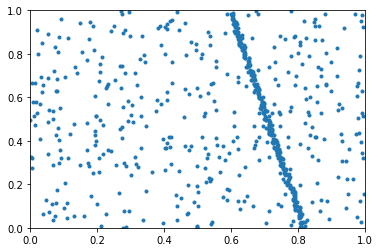

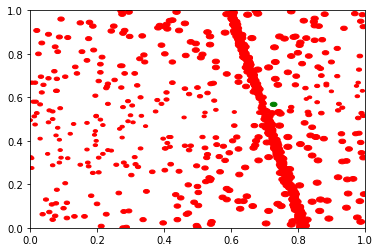

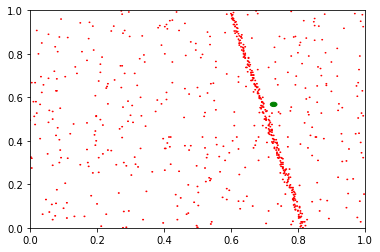

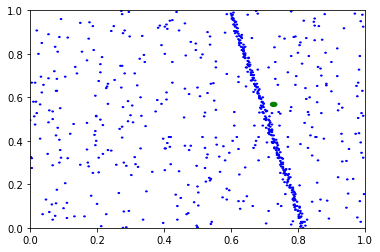

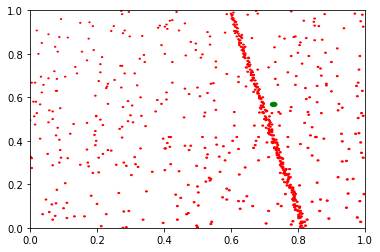

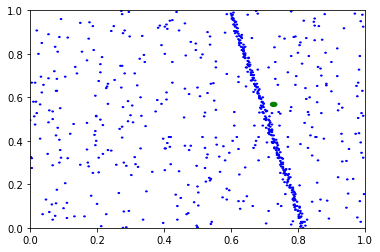

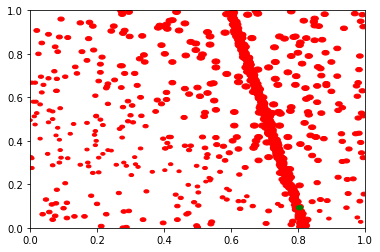

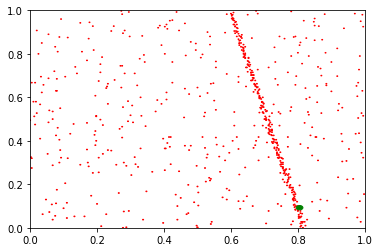

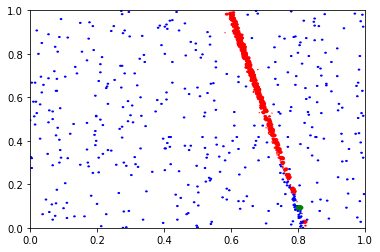

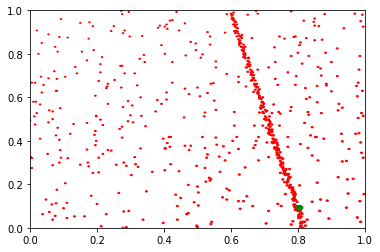

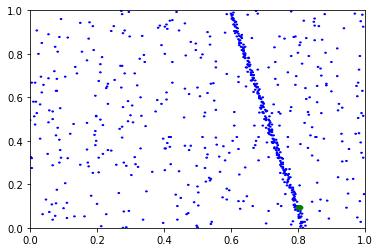

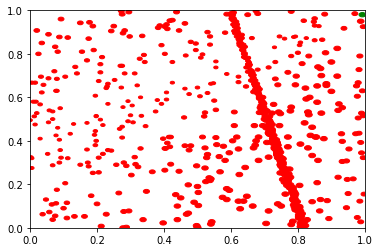

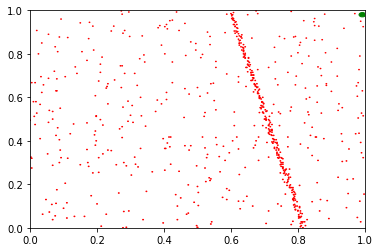

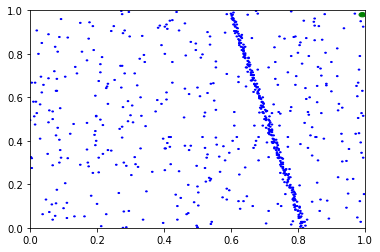

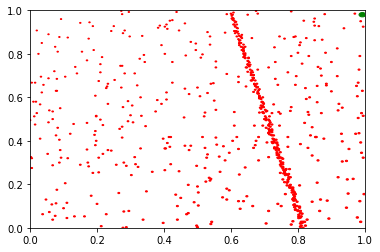

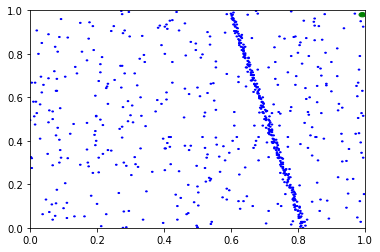

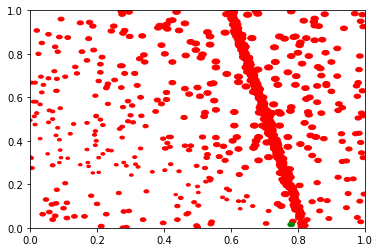

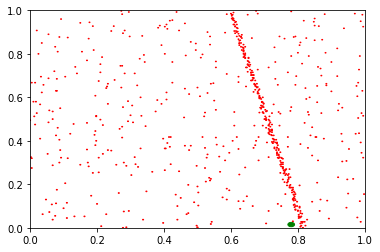

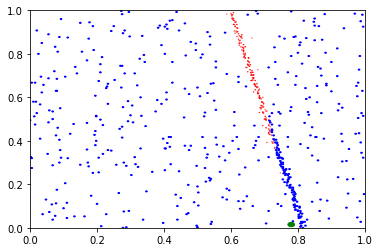

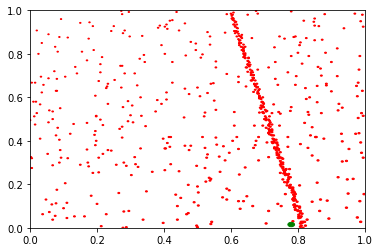

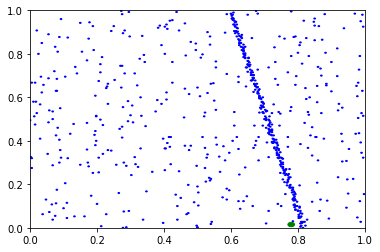

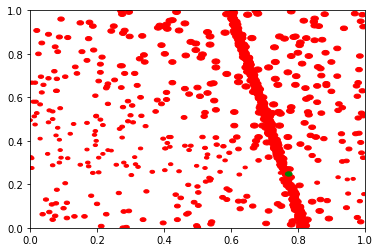

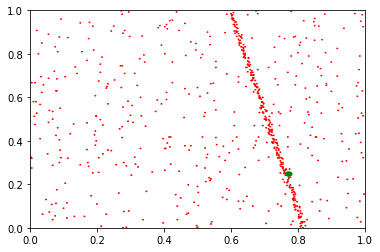

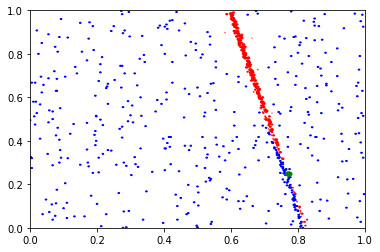

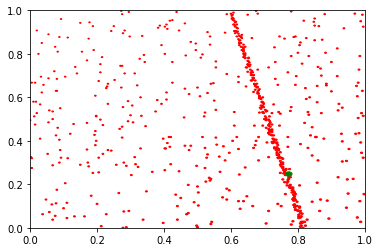

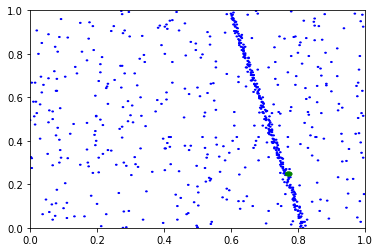

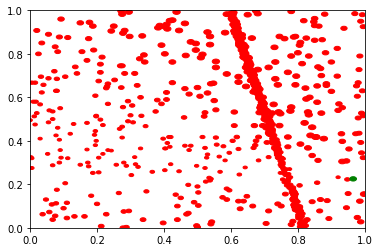

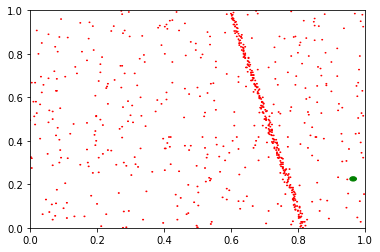

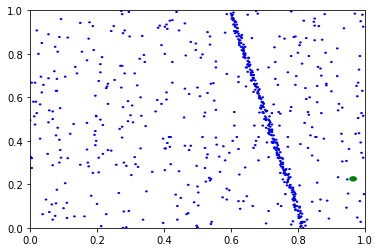

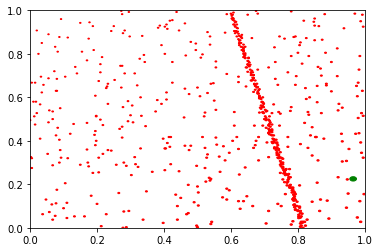

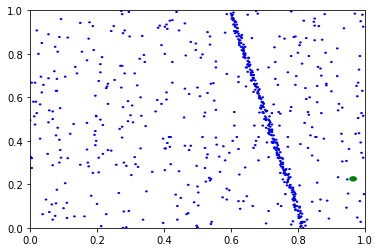

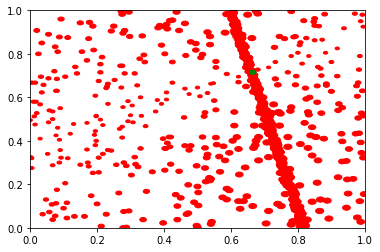

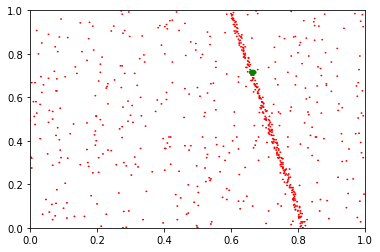

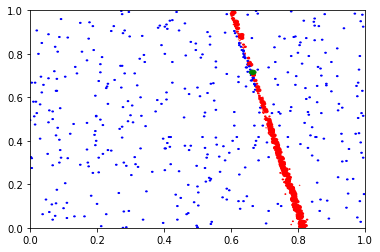

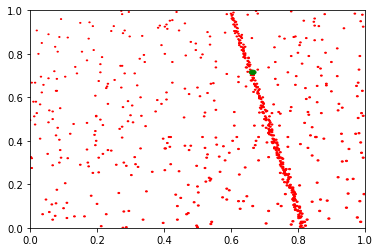

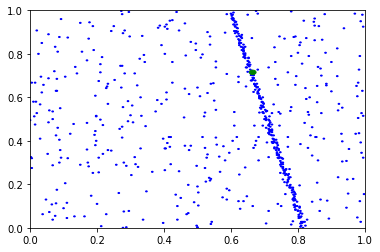

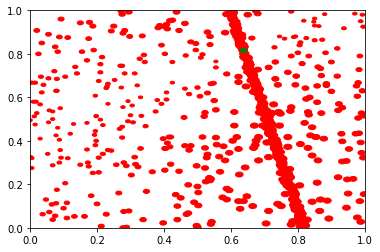

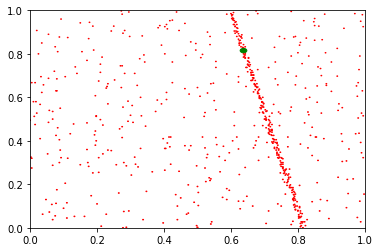

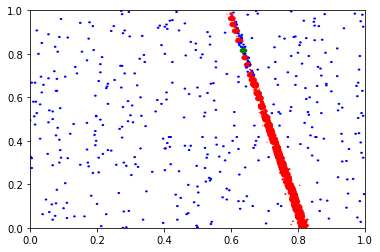

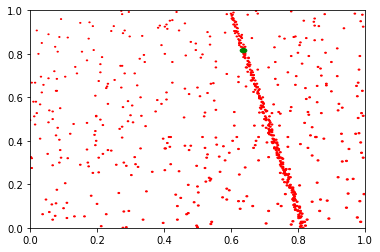

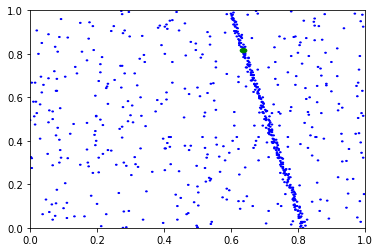

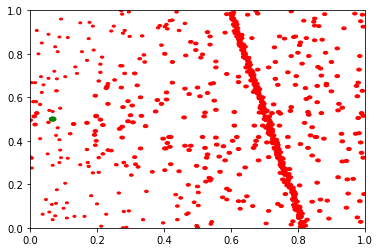

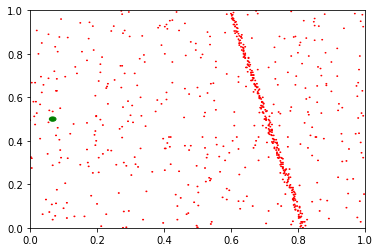

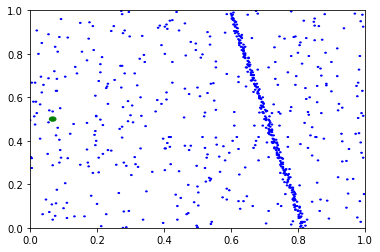

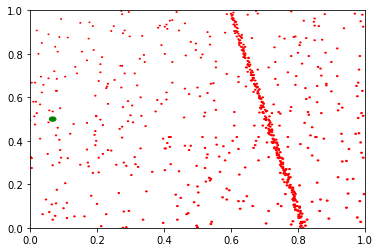

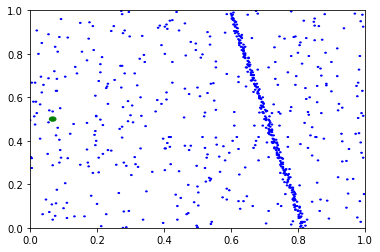

In [ ]:
def plot_weights(weights, coord, p1, image, ref=False):
    #print(max(weights), min(weights))
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    n = len(weights)

    for i in range(n):
        (x, y) = coord[i]
        w = weights[i]
        if isinstance(w, list):
            w = w[0]
        #r = (exp(10*w)/exp(7))
        #if ref:*
        #r = exp(8*w)/exp(6)/image[0]
        r = 5*w/image[0]
        circle = plt.Circle((x, y), r, color='r')
        if r <= 5*10**(-4):
            circle = plt.Circle((x, y), 1./image[0], color='b')

        ax.add_artist(circle)
    #print(p1)
    print("mean =", mean_weights(weights[:][0]))
    circle_1 = plt.Circle(p1, 4./image[0], color='g')
    ax.add_artist(circle_1)
    fig.show()
    

def test_nn(model, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X = []
        coord = []
        weights_ref = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature=compute_features(data, i1, i2)
                X.append(feature)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                #area = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                
                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():
            X_tensor = torch.Tensor(X)
            weights = model(X_tensor)
        
        #plot_weights(weights, coord, p1, image)
        plot_weights(weights_ref, coord, p1, image, ref=True)
        
def test_nn_compare(model1, model2, model3, image, sigma, nbr_inliers, nbr_outliers):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n_inliers_precise = len(data[0])-nbr_outliers
    dist_ref = dist_points_to_line(data, line_ref, image, n_inliers_precise)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(10):
        i1 = np.random.randint(n)
        X_nn = []
        X_nn_old = []
        X_patch1 = []
        X_patch2 = []
        X_patch3 = []
        coord = []
        weights_ref = []
        weights_ref_old = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature_nn=compute_features_k(data, i1, i2)
                X_nn.append(feature_nn)
                
                feature1, feature2, feature3=compute_features_patch(data, i1, i2, image)
                X_patch1.append(feature1)
                X_patch2.append(feature2)
                X_patch3.append(feature3)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                area_old = loss_weights(line_ref, line, image)
                area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                weights_ref.append([area])
                weights_ref_old.append([area_old])

                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():                
            X_tensor_nn = torch.Tensor(X_nn)
            weights1 = model1(X_tensor_nn.to(DEVICE))
            
            X_tensor_patch1 = torch.Tensor(X_patch1)
            X_tensor_patch2 = torch.Tensor(X_patch2)
            X_tensor_patch3 = torch.Tensor(X_patch3)
            weights2 = model2((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))
            
            weights3 = model3(X_tensor_nn.to(DEVICE))

        
        plot_weights(weights_ref_old, coord, p1, image)
        plot_weights(weights3, coord, p1, image)
        
        plot_weights(weights_ref, coord, p1, image)
        plot_weights(weights1, coord, p1, image)
        plot_weights(weights2, coord, p1, image)


test_nn_compare(model, model_patch, model_old_loss, image_size, sigma_noise, nbr_inliers, nbr_outliers)

### Compute weights from model

In [163]:
def compute_weights_ref(line_ref, image, data, i1):
    coord = []
    weights_ref = []
    p1 = (data[0][i1], data[1][i1])
    n = len(data[0])
    for i2 in range(n):
        if i2==i1:
            weights_ref.append(0)
        else:
            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2, image)
            area = loss_weights(line_ref, line, image)
            weights_ref.append(area)

        coord.append((data[0][i2], data[1][i2]))
    return weights_ref


In [164]:
def compute_weights(model, data, i1, image):
    n = len(data[0])

    p1 = data[0][i1], data[1][i1]
    X = []
    coord = []
    for i2 in range(n):
        if i2!=i1:
            feature=compute_features(data, i1, i2)
            X.append(feature)
            X_tensor = torch.Tensor(X)


            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2, image)

            coord.append((data[0][i2], data[1][i2]))
            
    model.eval()
    with torch.no_grad():
        weights_predict = model(X_tensor)
    
    weights = []
    k = 0
    for i in range(n):
        if i == i1:
            weights.append(0)
            k = 1
        else:
            weights.append(weights_predict[i-k][0])
    
    
    assert len(weights) == len(data[0])
            
    return weights

        

def sample_from_weights(data, weights, sigma=5):
    n = len(data[0])
    x1 = np.random.randint(n)
    if max(weights) == 0:
        return x1
    while weights[x1] == 0:
        x1 = np.random.randint(n)
    for k in range(1000):
        x2 = int(np.random.normal(loc=x1, scale=sigma))
        while x2 < 0 or x2 >= n:
            x2 = int(np.random.normal(loc=x1, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2

    
    x2 = int(np.random.normal(loc=x1, scale=sigma))
    while x2 < 0 or x2 >= n:
        x2 = int(np.random.normal(loc=x1, scale=sigma))
    alpha = weights[x2]/weights[x1]
    u = random.uniform(0, 1)
    if u <= alpha:
        x1 = x2
    return x1


### Ransac

In [165]:
def get_inliers(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = [[], []]
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb)/sqrt(1+a*a) < threshold:
            Inliers[0].append(x)
            Inliers[1].append(y)
    return Inliers

def get_model(model, data, image, line_ref=None):
    n = len(data[0])
    i1 = np.random.randint(n)
    if model is not None:
        weights = compute_weights(model, data, i1, image)
    else:
        weights = compute_weights_ref(line_ref, image, data, i1)
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line #, weights, i1


def update_stopping_criterion(k, inliers, proba):
    if k >= 150:
        return True
    return False


def ransac(data, threshold, image, proba, line_ref=None, model=None, compare=False):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model(model, data, image, line_ref)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [166]:
image = image_size
sigma = sigma_noise
n_inliers=150
n_outliers=50
proba = 0.1

line = generate_line(image)
data = generate_data(line, image, sigma, n_inliers, n_outliers)
    
threshold = 12
    
k = 0
inliers_max = [[], []]
line_max = None
end = False
line_ref = line

In [167]:
sample = []
line2, weights, i1 = get_model(model, data, image, sample, line_ref)
p1 = (data[0][i1], data[1][i1])
inliers = get_inliers(data, line2, threshold, image)
if len(inliers[0]) > len(inliers_max[0]):
    inliers_max = inliers
    line_max = line2
k += 1
end = update_stopping_criterion(k, inliers, proba)

print("------------------------------------")
print("nbr inliers = ", len(inliers[0]))
print("line = ", line2)
print("max inliers so far = ", len(inliers_max[0]))
print("end = ", end)
print("sample = ", sample)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax, c='b')
ax.plot([p1[0]], [p1[1]], c='g')
plot_data(inliers, ax, c='r')
plot_line(line2, image, ax, c='g')
fig.show()

coord = [(data[0][i], data[1][i]) for i in range(len(data[0]))]
plot_weights(weights, coord, p1, image, ref=True)


TypeError: get_model() takes from 3 to 4 positional arguments but 5 were given

prediction =  (-7.14, 707.18)
ref =  (-7.23, 720.11)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(-7.14, 707.18)

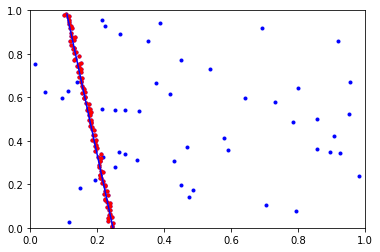

In [168]:
def test_weights_ref(image, sigma, n_inliers=150, n_outliers=50):
    line = generate_line(image)
    data = generate_data(line, image, sigma, n_inliers, n_outliers)
    
    threshold = 5
    proba = 0.1
    
    line_predict, inliers = ransac(data, threshold, image, proba, line_ref=line)
    
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax, c='b')
    plot_data(inliers, ax, c='r')
    #plot_line(line, image, ax, c='g')
    plot_line(line_predict, image, ax, c='b')
    fig.show()
    
    print("prediction = ", line_predict)
    print("ref = ", line)
    
    return line_predict

test_weights_ref(image_size, sigma_noise)

### Compare with and without weights

In [169]:
def get_model_uniform(data, image):
    n = len(data[0])
    i1 = np.random.randint(n)
    i2 = np.random.randint(n)
    while i1 == i2:
        i2 = np.random.randint(n)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def ransac_uniform(data, threshold, image, proba):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model_uniform(data, image)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    return line_max, inliers_max, nbr_inliers

def ransac_weights_ref(data, threshold, image, proba, line_ref):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    while not end:
        line = get_model(None, data, image, line_ref)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    return line_max, inliers_max, nbr_inliers

In [170]:
def plot_lines(data, line1, line2, image):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax, c='b')
    plot_line(line1, image, ax, c='g')
    #plot_line(line2, image, ax, c='r')
    fig.show()


def compare_uniform(image, sigma, n_inliers, n_outliers, model=None,average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    nbr_inliers_sample = [0]*it
    nbr_inliers_uniform = [0]*it
    
    for k in range(average):
        print(k)
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, image, proba, line_ref=Lines[k], model=model, compare=True)
        line_predict2, inliers2, nbr_inliers2 = ransac_uniform(Datas[k], threshold, image, proba)
        plot_lines(Datas[k], line_predict1, line_predict2, image)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_uniform[j] += nbr_inliers2[j]
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_uniform[j] /= average
        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_uniform, c='r')
    fig.show()
    
    print("done")



In [ ]:
#image_size = [400, 400]
#n_inliers = 300
#n_outliers = 400

compare_uniform(image_size, sigma_noise, n_inliers=nbr_inliers, n_outliers=nbr_outliers, model=model)

### Choose first point

In [ ]:
def get_density(data, image, k, n_x, n_y):
    p = (data[0][k]*image[0], data[1][k]*image[1])
    d_x = image[0]*n_x
    d_y = image[1]*n_y
    min_x = max(p[0]-d_x, 0)
    max_x = min(p[0]+d_x, image[0])
    min_y = max(p[1]-d_y, 0)
    max_y = min(p[1]+d_y, image[1])
    counter = 0
    n = len(data[0])
    for i in range(n):
        (x, y) = (data[0][i]*image[0], data[1][i]*image[1])
        if x >= min_x and x <= max_x and y >= min_y and y <= max_y:
            counter += 1
    return counter/((max_x-min_x)*(max_y-min_y))


def get_density_vector(data, image, n_x, n_y):
    n = len(data[0])
    densities = []
    for k in range(n):
        w = get_density(data, image, k, n_x, n_y)
        densities.append(w)
    return densities

In [ ]:
def get_model2(model, data, image, densities):
    n = len(data[0])
    i1 = sample_from_weights(data, densities)
    weights = compute_weights(model, data, i1, image)
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def ransac2(data, threshold, image, proba, model, n_x, n_y, compare=False):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    while not end:
        line = get_model2(model, data, image, densities)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [ ]:
def get_model3(model, data, image, densities, last_weights):
    n = len(data[0])
    
    threshold = 0.9
    if last_weights is not None and mean_weights(last_weights) >= threshold:
        i1 = sample_from_weights(data, last_weights)
    else:
        i1 = sample_from_weights(data, densities)
    i1 = np.random.randint(n)    
    weights = compute_weights(model, data, i1, image)
    #print(mean_weights(weights))
    i2 = sample_from_weights(data, weights)
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line, weights


def ransac3(data, threshold, image, proba, model, n_x, n_y, compare=False):
    k = 0
    inliers_max = [[], []]
    line_max = None
    end = False
    nbr_inliers = []
    densities = get_density_vector(data, image, n_x, n_y)
    previous_weights = None
    while not end:
        line, previous_weights = get_model3(model, data, image, densities, previous_weights)
        inliers = get_inliers(data, line, threshold, image)
        if len(inliers[0]) > len(inliers_max[0]):
            inliers_max = inliers
            line_max = line
        nbr_inliers.append(len(inliers_max[0]))

        k += 1
        end = update_stopping_criterion(k, inliers, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers[0]))
        #print("line = ", line)
        #print("max inliers so far = ", len(inliers_max[0]))
    if compare:
        return line_max, inliers_max, nbr_inliers
    return line_max, inliers_max

In [ ]:
#Test to set threshold

line = generate_line(image_size)
data = generate_data(line, image_size, sigma_noise, nbr_inliers, nbr_outliers)
threshold = 5
proba = 0.1
ransac3(data, threshold, image_size, proba, model, n_x=0.05, n_y=0.05, compare=True)

In [ ]:
def compare_all(image, sigma, model, n_inliers, n_outliers, average=5):
    Lines = []
    Datas = []
    for k in range(average):
        line = generate_line(image)
        data = generate_data(line, image, sigma, n_inliers, n_outliers)
        Lines.append(line)
        Datas.append(data)
    
    threshold = 5
    proba = 0.1
    
    it = 150
    nbr_inliers_sample = [0]*it
    nbr_inliers_sample2 = [0]*it
    nbr_inliers_sample3 = [0]*it
    nbr_inliers_uniform = [0]*it
    nbr_inliers_ref = [0]*it

    
    for k in range(average):
        line_predict1, inliers1, nbr_inliers1 = ransac(Datas[k], threshold, image, proba, line_ref=Lines[k], model=model, compare=True)
        print(1)
        line_predict2, inliers2, nbr_inliers2 = ransac2(Datas[k], threshold, image, proba, model, n_x=0.05, n_y=0.05, compare=True)
        print(2)
        line_predict3, inliers3, nbr_inliers3 = ransac3(Datas[k], threshold, image, proba, model, n_x=0.05, n_y=0.05, compare=True)
        print(3)
        line_predict4, inliers4, nbr_inliers4 = ransac_uniform(Datas[k], threshold, image, proba)
        print(4)
        line_predict5, inliers5, nbr_inliers5 = ransac_weights_ref(Datas[k], threshold, image, proba, line_ref=Lines[k])
        print(5)

        plot_lines(Datas[k], line_predict1, line_predict2, image)
        
        for j in range(it):
            nbr_inliers_sample[j] += nbr_inliers1[j]
            nbr_inliers_sample2[j] += nbr_inliers2[j]
            nbr_inliers_sample3[j] += nbr_inliers3[j]
            nbr_inliers_uniform[j] += nbr_inliers4[j]
            nbr_inliers_ref[j] += nbr_inliers5[j]

            
    
    for j in range(it):
        nbr_inliers_sample[j] /=average
        nbr_inliers_sample2[j] /=average
        nbr_inliers_sample3[j] /=average
        nbr_inliers_uniform[j] /= average
        nbr_inliers_ref[j] /= average

        
    fig, ax = plt.subplots()
    ax.plot(nbr_inliers_sample, c='g')
    ax.plot(nbr_inliers_sample2, c='b')
    ax.plot(nbr_inliers_sample3, c='r')
    ax.plot(nbr_inliers_uniform, c='black')
    ax.plot(nbr_inliers_ref, c='orange')

    fig.show()
    
    print("done")
    

In [ ]:
compare_all(image_size, sigma_noise, model, n_inliers=nbr_inliers, n_outliers=nbr_outliers, average=5)

In [ ]:
model2 = Weights().to(DEVICE)

sigma_noise = [2, 2]
image_size = (400, 400)
nbr_inliers2=300
nbr_outliers2=250

train_model(model2, image_size, sigma_noise, 50, 529, 60, 100, nbr_inliers2, nbr_outliers2)

test_nn(model2, image_size, sigma_noise, nbr_inliers2, nbr_outliers2)

In [ ]:
compare_all(image_size, sigma_noise, model2, n_inliers=nbr_inliers2, n_outliers=nbr_outliers2, average=3)

In [ ]:
model3 = Weights().to(DEVICE)

sigma_noise = [2, 2]
image_size = (400, 400)
nbr_inliers3=400
nbr_outliers3=500

train_model(model3, image_size, sigma_noise, 50, 625, 100, 100, nbr_inliers3, nbr_outliers3)

test_nn(model3, image_size, sigma_noise, nbr_inliers3, nbr_outliers3)

In [ ]:
compare_all(image_size, sigma_noise, model3, n_inliers=nbr_inliers3, n_outliers=nbr_outliers3, average=3)

### 2 Lines

In [171]:
def get_inliers_couple(data, line, threshold, image):
    a, b = line
    X, Y = data
    Inliers = []
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        (xb, yb) = x*image[0], y*image[1]
        if abs((a*xb+b) - yb)/sqrt(1+a*a) < threshold:
            Inliers.append((x, y))
    return Inliers

def change_format(inliers):
    L = [[], []]
    for (x, y) in inliers:
        L[0].append(x)
        L[1].append(y)
    return L

In [172]:
def stopping_criterion_multi(step, inliers, total, proba):
    if step < 5000:
        return False
    
    end = True
    for n_inliers in inliers:
        x = 1 - (n_inliers/total)**2
        if x**step > proba:
            end = False
    return end

def nbr_intersection(inliers1, inliers2):
    counter = 0
    if len(inliers1) >= len(inliers2):
        for (x, y) in inliers1:
            if (x, y) in inliers2:
                counter += 1
    else:
         for (x, y) in inliers2:
            if (x, y) in inliers1:
                counter += 1
    return counter
            


def ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image, proba):
    step = 0
    inliers_max = []
    nbr_inliers_max = []
    line_max = []
    end = False
    nbr_inliers = []
    n = len(data[0])
    counter = 0
    
    while not end:
        if (step % 1000 == 0):
            print("step = ", step)
            print("counter = ", counter)
        line = get_model_uniform(data, image)
        inliers = get_inliers_couple(data, line, threshold, image)
        if len(inliers) > threshold_nbr_inliers:
            counter += 1
            max_inter = -1
            max_inliers_inter = threshold_intersection - 1
            for k in range(len(inliers_max)):
                inter = nbr_intersection(inliers, inliers_max[k])
                #print("intersection = ", inter)
                if inter > max_inliers_inter:
                    #print(len(inliers), len(inliers_max[k]))
                    #print(sorted(inliers))
                    #print()
                    #print(sorted(inliers_max[k]))
                    max_inliers_inter = inter
                    max_inter = k
                    
            if max_inter == -1:
                print("new line")
                line_max.append(line)
                inliers_max.append(inliers)
                nbr_inliers_max.append(len(inliers))
            else:
                #print("change line", max_inter, ",", "intersection =", max_inliers_inter)
                if len(inliers) > nbr_inliers_max[max_inter]:
                    line_max[max_inter] = line
                    inliers_max[max_inter] = inliers
                    nbr_inliers_max[max_inter] = len(inliers)

        step += 1
        end = stopping_criterion_multi(step, nbr_inliers_max, n, proba)
        
        #print("------------------------------------")
        #print("nbr inliers = ", len(inliers))
        #print("line = ", line)
        #print("max inliers so far = ", nbr_inliers_max)
    return line_max, inliers_max, nbr_inliers

In [173]:
def generate_data_multi_line(lines, image, sigma, n_inliers, n_outliers):
    L_X = []
    L_Y = []
    for (a, b) in lines:
        Points = []
        for x in range(image[0]):
            y = a*x+b
            if y >= 0 and y < image[1]:
                p = np.array([x, y])
                Points.append(p)
        covariance = np.diag(np.array(sigma) ** 2)
        n_i = max(1, n_inliers // len(Points))
        for point in Points:
            sample = np.random.multivariate_normal(point, covariance, n_i)
            sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
            sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
            L_X.extend(sample_X)
            L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)


In [174]:
image_size = (200, 200)
n_inliers = 250
n_outliers = 400
sigma_noise = (2, 2)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


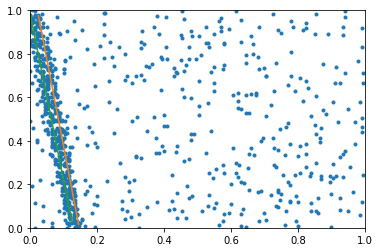

In [204]:
line1 = generate_line(image_size)
line2 = generate_line(image_size)
data = generate_data_multi_line([line1, line2], image_size, sigma_noise, n_inliers, n_outliers)

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plot_data(data, ax)
plot_line(line1, image_size, ax)
plot_line(line2, image_size, ax)
fig.show()

step =  0
counter =  0
new line
new line
step =  1000
counter =  271
step =  2000
counter =  561
step =  3000
counter =  834
step =  4000
counter =  1117
nbr_lines =  2


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


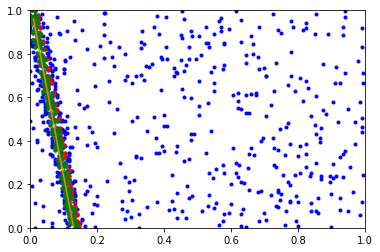

In [206]:
proba = 0.05
threshold = 2.5
threshold_nbr_inliers = 100
threshold_intersection = 20

lines_pred, inliers_pred, nbr_inliers_pred = ransac_uniform_multi(data, threshold, threshold_nbr_inliers, threshold_intersection, image_size, proba)
print("nbr_lines = ", len(lines_pred))

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plot_data(data, ax, c='b')
colors = ['r', 'g', 'b']
for i in range(len(inliers_pred)):
    plot_data(change_format(inliers_pred[i]), ax, c=colors[i % 3])
    plot_line(lines_pred[i], image_size, ax)



fig.show()